In [9]:
#!pip install SciencePlots

In [10]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scienceplots

import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [11]:
# set plot to science:
plt.style.use('science')

# set path to save figure:
path = r"C:\Users\...\...\..."

In [12]:
# Force white background and clear ticks
plt.rcParams.update({
    "figure.facecolor": "white",       # Figure background
    "axes.facecolor": "white",         # Axes background
    "savefig.facecolor": "white",      # Saved figure background
    "xtick.color": "black",            # X tick color
    "ytick.color": "black",            # Y tick color
    "axes.edgecolor": "black",         # Axis border
    "axes.labelcolor": "black",        # Axis label color
    "text.color": "black",             # General text color
#    "grid.color": "lightgray"          # Optional: adjust grid color
})

In [13]:

# Function to generate samples from a normal distribution truncated to [0,1]
def truncated_normal(loc, scale, size):
    samples = np.random.normal(loc, scale, size)
    return np.clip(samples, 0, 1)



In [15]:
# Generate red and blue data
red_data = np.concatenate([
    truncated_normal(0.15, 0.10, 2000),
    truncated_normal(0.90, 0.08, 2000)
])

blue_data = np.concatenate([

    truncated_normal(0.15, 0.08, 200),

    truncated_normal(0.65, 0.14, 400),
    truncated_normal(0.70, 0.20, 1400),
    truncated_normal(0.75, 0.16, 500),

])

In [16]:
# Generate red and blue data
red_data_fair = np.concatenate([
    truncated_normal(0.15, 0.10, 2000),
    truncated_normal(0.70, 0.10, 500),
    truncated_normal(0.80, 0.10, 750),
    truncated_normal(0.90, 0.08, 750)
])

blue_data_fair = np.concatenate([
    truncated_normal(0.15, 0.08, 200),

    truncated_normal(0.40, 0.10, 200),
    truncated_normal(0.50, 0.08, 100),
    truncated_normal(0.55, 0.08, 500),
    truncated_normal(0.65, 0.14, 500),
    truncated_normal(0.70, 0.20, 500),
    truncated_normal(0.75, 0.16, 200),
    truncated_normal(0.80, 0.06, 200),
    truncated_normal(0.85, 0.06, 100),
    truncated_normal(0.90, 0.06, 200),
])

In [17]:
def demographic_parity(y_pred, z_values, threshold=0.5):
    """
    Compute the demographic parity between two groups.

    Parameters:
    y_pred (array-like): Predicted values.
    z_values (array-like): Binary values indicating the group membership of each sample.
    threshold (float, optional): Threshold value for the predicted values. Default is 0.5.

    Returns:
    float: The computed demographic parity value.
    """
    # Extract the predicted values for each group and apply the threshold if it is not None
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]

    parity = abs(y_z_1.mean() - y_z_0.mean())

    return parity

# Compute the absolute average differences
tau_values = np.linspace(0, 1, 50)
average_differences = []
average_differences_fair = []

for tau in tau_values:
    z_values = np.concatenate([np.ones(len(red_data)), np.zeros(len(blue_data))])
    y_pred = np.concatenate([red_data, blue_data])
    avg_diff = demographic_parity(y_pred, z_values, threshold=tau)
    average_differences.append(avg_diff)

    z_values_fair = np.concatenate([np.ones(len(red_data_fair)), np.zeros(len(blue_data_fair))])
    y_pred_fair = np.concatenate([red_data_fair, blue_data_fair])
    avg_diff_fair = demographic_parity(y_pred_fair, z_values_fair, threshold=tau)
    average_differences_fair.append(avg_diff_fair)

# Convert to a pandas Series for easy rolling average (ignores NaNs by default)
average_differences = pd.Series(average_differences)
smoothed_differences = average_differences.rolling(window=3, center=True, min_periods=1).mean()

average_differences_fair = pd.Series(average_differences_fair)
smoothed_differences_fair = average_differences_fair.rolling(window=3, center=True, min_periods=1).mean()

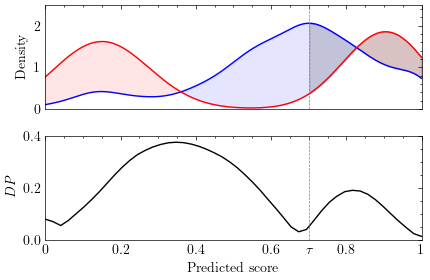

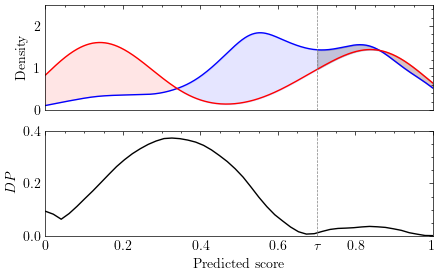

In [18]:
# Define common grid
x_grid = np.linspace(0, 1, 500)
tau = 0.7

# KDEs for biased data
kde_red = gaussian_kde(red_data, bw_method=0.2)
kde_blue = gaussian_kde(blue_data, bw_method=0.2)
red_kde_vals = kde_red(x_grid)
blue_kde_vals = kde_blue(x_grid)

# Plot biased model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 3), sharex=True, facecolor='white')

# Plot KDEs
ax1.plot(x_grid, blue_kde_vals, color='blue', label=f'$S=0$')
ax1.plot(x_grid, red_kde_vals, color='red', label=f'$S=1$')

ax1.fill_between(x_grid, red_kde_vals, blue_kde_vals, where=(red_kde_vals > blue_kde_vals),
                 interpolate=True, color='red', alpha=0.1)
ax1.fill_between(x_grid, red_kde_vals, blue_kde_vals, where=(blue_kde_vals > red_kde_vals),
                 interpolate=True, color='blue', alpha=0.1)

# Highlight region x in [tau, 1]
mask = x_grid >= tau
upper_kde = np.maximum(red_kde_vals, blue_kde_vals)
ax1.fill_between(x_grid[mask], red_kde_vals[mask], blue_kde_vals[mask],
                 interpolate=True, color='black', alpha=0.15)

ax1.axvline(tau, color='grey', linestyle='--', linewidth=0.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 2.5)
#ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Density")
#ax1.set_title("Model output (biased)")
#ax1.legend()

# Plot DP curve
ax2.plot(tau_values, smoothed_differences, color='black')
ax2.set_xlabel("Predicted score")
ax2.set_ylabel("$DP$")
ax2.set_xlim(0, 1)
ax2.set_ylim(0,0.4)
#ax2.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax2.axvline(tau, color='grey', linestyle='--', linewidth=0.5)
ax2.set_xticks([0, 0.2, 0.4, 0.6, tau, 0.8, 1])
ax2.set_xticklabels([r"$0$", r"$0.2$", r"$0.4$", r"$0.6$", r"$\tau$", r"$0.8$", r"$1$"])

plt.tight_layout()

# save figure as pdf, png, jpg:
plt.savefig(os.join(path, "biased_model.pdf"), format='pdf', bbox_inches='tight')
plt.savefig(os.join(path, "biased_model.png"), format='png', bbox_inches='tight')
plt.savefig(os.join(path, "biased_model.jpg"), format='jpg', bbox_inches='tight')
plt.show()

# KDEs for fair data
kde_red_fair = gaussian_kde(red_data_fair, bw_method=0.2)
kde_blue_fair = gaussian_kde(blue_data_fair, bw_method=0.2)
red_kde_vals_fair = kde_red_fair(x_grid)
blue_kde_vals_fair = kde_blue_fair(x_grid)

# Plot fair model
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 3), sharex=True)

# Plot KDEs
ax1.plot(x_grid, blue_kde_vals_fair, color='blue', label=f'$S=0$')
ax1.plot(x_grid, red_kde_vals_fair, color='red', label=f'$S=1$')

ax1.fill_between(x_grid, red_kde_vals_fair, blue_kde_vals_fair, where=(red_kde_vals_fair > blue_kde_vals_fair),
                 interpolate=True, color='red', alpha=0.1)
ax1.fill_between(x_grid, red_kde_vals_fair, blue_kde_vals_fair, where=(blue_kde_vals_fair > red_kde_vals_fair),
                 interpolate=True, color='blue', alpha=0.1)

# Highlight region x in [tau, 1]
mask = x_grid >= tau
upper_kde_fair = np.maximum(red_kde_vals_fair, blue_kde_vals_fair)
ax1.fill_between(x_grid[mask], red_kde_vals_fair[mask], blue_kde_vals_fair[mask],
                 interpolate=True, color='black', alpha=0.15)

ax1.axvline(tau, color='grey', linestyle='--', linewidth=0.5)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 2.5)
#ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Density")
#ax1.set_title("Model output (decision-centric fairness)")
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot DP curve
ax2.plot(tau_values, smoothed_differences_fair, color='black')
ax2.set_xlabel("Predicted score")
ax2.set_ylabel("$DP$")
ax2.set_xlim(0, 1)
ax2.set_ylim(0,0.4)
ax2.axvline(tau, color='grey', linestyle='--', linewidth=0.5)
ax2.set_xticks([0, 0.2, 0.4, 0.6, tau, 0.8, 1])
ax2.set_xticklabels([r"$0$", r"$0.2$", r"$0.4$", r"$0.6$", r"$\tau$", r"$0.8$", r"$1$"])

#plt.tight_layout()

# save figure as pdf, png, jpg:
plt.savefig(os.join(path, "fair_model.pdf"), format='pdf', bbox_inches='tight')
plt.savefig(os.join(path, "fair_model.png"), format='png', bbox_inches='tight')
plt.savefig(os.join(path, "fair_model.jpg"), format='jpg', bbox_inches='tight')

plt.show()

